# Bibliotecas

In [78]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave, imshow
from skimage.color import rgb2gray, gray2rgb, rgb2hsv
from sklearn.cluster import KMeans
from skimage import restoration, filters
from skimage import img_as_ubyte

from sklearn.mixture import GaussianMixture
from sklearn import metrics


## 1. Utilizando   a   base   de   imagens   “ultrassound.zip”   disponibilizada   no   SIGAA,   realize  a segmentação das imagens das seguintes formas:

### I. Aplique o algoritmo K-means utilizando os pixels como pesos; 

In [130]:
def kMeansTransform(path, name_img, n_clusters=8):
    
    img = imread(path + name_img)
    
    if len(img.shape) > 2:  img = rgb2gray(img)

    pixel_values = img.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)
    
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto").fit(pixel_values)
    
    Z_image = kmeans.predict(pixel_values)
    Z_image = Z_image.reshape(img.shape)
    
    _zImageCopy = np.zeros_like(Z_image)
    for x in kmeans.cluster_centers_:
        if x >= 0.24 and x <= 0.40:
            new_img = Z_image == list(kmeans.cluster_centers_).index(x)
            # new_img = filters.median(new_img)
            _zImageCopy += new_img
    
    _zImageCopy = cv2.normalize(src=_zImageCopy, dst=None, alpha=0,
                          beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    os.makedirs("../ultrassound/seg_kmeans/", exist_ok=True)
    imsave('../ultrassound/seg_kmeans/{}'.format(name_img), _zImageCopy)


In [131]:
path = "../ultrassound/cropped/"
dirs = os.listdir(path)

for item in dirs:
    if os.path.isfile(path + item):
        # print(path + item)
        kMeansTransform(path, item)

### II. Implemente duas segmentações utilizando os algoritmos de binarização local e global (Niblack e Otsu, respectivamente);

In [61]:
def seg_otsu(path, name_img):
    
    img = imread(path + name_img)

    if len(img.shape) > 2:
        img = rgb2gray(img)

    threshold = filters.threshold_otsu(img)
    binarized_img = (img > threshold)*1
    
    binarized_img_norm = cv2.normalize(src=binarized_img, dst=None, alpha=0,
                                beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    os.makedirs("../ultrassound/seg_otsu/", exist_ok=True)
    imsave('../ultrassound/seg_otsu/{}'.format(name_img), binarized_img_norm)
    

In [138]:
def seg_niblack(path, name_img):

    img = imread(path + name_img)

    if len(img.shape) > 2:
        img = rgb2gray(img)

    threshold = filters.threshold_niblack(img)
    binarized_img = (img > threshold)*1

    binarized_img_norm = cv2.normalize(src=binarized_img, dst=None, alpha=0,
                                       beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    os.makedirs("../ultrassound/seg_niblack/", exist_ok=True)
    imsave('../ultrassound/seg_niblack/{}'.format(name_img), binarized_img_norm)


In [139]:
path = "../ultrassound/cropped/"
dirs = os.listdir(path)

for item in dirs:
    if os.path.isfile(path + item):
        # print(path + item)
        # seg_otsu(path, item)
        seg_niblack(path, item)


### III. Aplique   outro   algoritmo   de   agrupamento   que   utilize   também   a   posição espacial dos pixels como peso; 


In [151]:
def GaussianMixtureTransform(path, name_img):

    img = imread(path + name_img)

    if len(img.shape) > 2:
        img = rgb2gray(img)

    pixel_values = img.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)

    kmeans = GaussianMixture(n_components=8, random_state=0, init_params='kmeans').fit(pixel_values)
    
    Z_image = kmeans.predict(pixel_values)
    Z_image = Z_image.reshape(img.shape)
    
    _zImageCopy = np.zeros_like(Z_image)
    for x in kmeans.means_:
        if x >= 0.24 and x <= 0.40:
            new_img = Z_image == list(kmeans.means_).index(x)
            # new_img = filters.median(new_img)
            _zImageCopy += new_img

    _zImageCopy = cv2.normalize(src=_zImageCopy, dst=None, alpha=0,
                                beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    os.makedirs("../ultrassound/GaussianMixture/", exist_ok=True)
    imsave('../ultrassound/GaussianMixture/{}'.format(name_img), _zImageCopy)


In [152]:
path = "../ultrassound/cropped/"
dirs = os.listdir(path)

for item in dirs:
    if os.path.isfile(path + item):
        GaussianMixtureTransform(path, item)


## 2. Crie um método para escolher o foreground e o background automaticamente;

### 3 - Métricas de acurácia de segmentação

In [156]:
def metricsFunc_Classification(mask_01, mask_real):
    
    pixel_values_mask_01 = mask_01.reshape((-1,1))
    pixel_values_mask_01 = np.float32(pixel_values_mask_01)

    pixel_values_mask_02 = mask_real.reshape((-1,1))
    pixel_values_mask_02 = np.float32(pixel_values_mask_02)
    
    accScoreResult = metrics.accuracy_score(pixel_values_mask_01, pixel_values_mask_02)
    jaccard_score_result = metrics.jaccard_score(pixel_values_mask_01!=0, pixel_values_mask_02!=0)
    
    return [accScoreResult, jaccard_score_result]
    

def metricsFunc_Clustering(mask_01, mask_real):

    pixel_values_mask_01 = mask_01.reshape((-1,))
    pixel_values_mask_01 = np.float32(pixel_values_mask_01)

    pixel_values_mask_02 = mask_real.reshape((-1,))
    pixel_values_mask_02 = np.float32(pixel_values_mask_02)

    homogeneity_score_result = metrics.homogeneity_score(
        pixel_values_mask_01, pixel_values_mask_02)
    adjusted_rand_score_result = metrics.adjusted_rand_score(
        pixel_values_mask_01, pixel_values_mask_02)
    

    return [homogeneity_score_result, adjusted_rand_score_result]

def metricsGeneral(countClustering, countClassification):
    auxLen = len(countClustering)
    
    acc_general = 0
    jaccard_score_general = 0
    rand_score_general = 0
    homogeneity_general = 0
    for x in range(0, auxLen):
        acc_general += countClassification[x][0]
        jaccard_score_general += countClassification[x][1]
        homogeneity_general += countClustering[x][0]
        rand_score_general += countClustering[x][1]
    
    print("Acuracia General - {}\nJaccard Score General - {}\nHomogeneity General - {}\nRand Score General - {}".format(
        (acc_general/auxLen), (jaccard_score_general/auxLen), (homogeneity_general/auxLen), (rand_score_general/auxLen)))


In [147]:
path = "../ultrassound/masks/"
dirs = os.listdir(path)

countClustering = list()
countClassification = list()

print("Seg_Kmeans X REAL MASKS")

for item in dirs:
    if os.path.isfile(path + item) and item[-4:] == ".bmp":
        img1 = imread(
            "../ultrassound/seg_kmeans/" + item)
        img2 = imread(
            "../ultrassound/masks/" + item)
        countClassification.append(metricsFunc_Classification(img1, img2))
        countClustering.append(metricsFunc_Clustering(img1, img2))
        
metricsGeneral(countClustering, countClassification)


Seg_Kmeans X REAL MASKS
Acuracia General - 0.8485449654251219
Jaccard Score General - 0.34931175808214543
Homogeneity General - 0.20050614811794626
Rand Score General - 0.3388340024736301


In [157]:
path = "../ultrassound/masks/"
dirs = os.listdir(path)

countClustering = list()
countClassification = list()

print("GaussianMixture X REAL MASKS")

for item in dirs:
    if os.path.isfile(path + item) and item[-4:] == ".bmp":
        img1 = imread(
            "../ultrassound/GaussianMixture/" + item)
        img2 = imread(
            "../ultrassound/masks/" + item)
        countClassification.append(metricsFunc_Classification(img1, img2))
        countClustering.append(metricsFunc_Clustering(img1, img2))

metricsGeneral(countClustering, countClassification)


GaussianMixture X REAL MASKS
Acuracia General - 0.8511595286347317
Jaccard Score General - 0.35073883692236707
Homogeneity General - 0.2043732161042801
Rand Score General - 0.3403736048059349


In [149]:
path = "../ultrassound/masks/"
dirs = os.listdir(path)

countClustering = list()
countClassification = list()

print("seg_niblack X REAL MASKS")

for item in dirs:
    if os.path.isfile(path + item) and item[-4:] == ".bmp":
        img1 = imread(
            "../ultrassound/seg_niblack/" + item)
        img2 = imread(
            "../ultrassound/masks/" + item)
        countClassification.append(metricsFunc_Classification(img1, img2))
        countClustering.append(metricsFunc_Clustering(img1, img2))

metricsGeneral(countClustering, countClassification)


seg_niblack X REAL MASKS
Acuracia General - 0.45650378873076136
Jaccard Score General - 0.1372766224641242
Homogeneity General - 0.0008509879647913034
Rand Score General - 0.0034639021965045575


In [150]:
path = "../ultrassound/masks/"
dirs = os.listdir(path)

countClustering = list()
countClassification = list()

print("seg_otsu X REAL MASKS")

for item in dirs:
    if os.path.isfile(path + item) and item[-4:] == ".bmp":
        img1 = imread(
            "../ultrassound/seg_otsu/" + item)
        img2 = imread(
            "../ultrassound/masks/" + item)
        countClassification.append(metricsFunc_Classification(img1, img2))
        countClustering.append(metricsFunc_Clustering(img1, img2))

metricsGeneral(countClustering, countClassification)


seg_otsu X REAL MASKS
Acuracia General - 0.8195010938515764
Jaccard Score General - 0.42478952501230177
Homogeneity General - 0.2574265391071991
Rand Score General - 0.3619564359220417


https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

### 3 - Crie um relatório em formato de notebook com: 
#### I. O   embasamento   teórico   do   método   de   agrupamento   escolhido   para segmentação (etapa III da questão 1); 
#### II. As saídas das três metodologias de segmentação; 
#### III. O detalhamento do método de escolha do fore/background; 
#### IV. Os resultados obtidos com as métricas de avaliação; e
#### V. Uma conclusão explicando qual técnica foi melhor e o motivo.

-=-=-=-=-

### I. Resposta

O GaussianMixture é um algoritmo de clustering que identifica grupos ocultos em dados multivariados ou imagens. Ele trabalha criando modelos de distribuições Gaussianas para cada cluster e ajustando-os aos dados de treinamento. Isso permite que ele lidem com clusters com formas diferentes, como elipses ou formas mais complexas. Além disso, ele também atribui probabilidades aos pontos de dados para mostrar quão forte é a sua pertença a um determinado cluster.

O GaussianMixture pode ser usado para melhorar os resultados de segmentação, mas é importante ter em mente que ele pode ser demorado e afetado por valores iniciais impróprios. Além disso, ele precisa de uma boa quantidade de dados para produzir resultados confiáveis.

https://towardsdatascience.com/gaussian-mixture-models-vs-k-means-which-one-to-choose-62f2736025f0


### II. Resposta

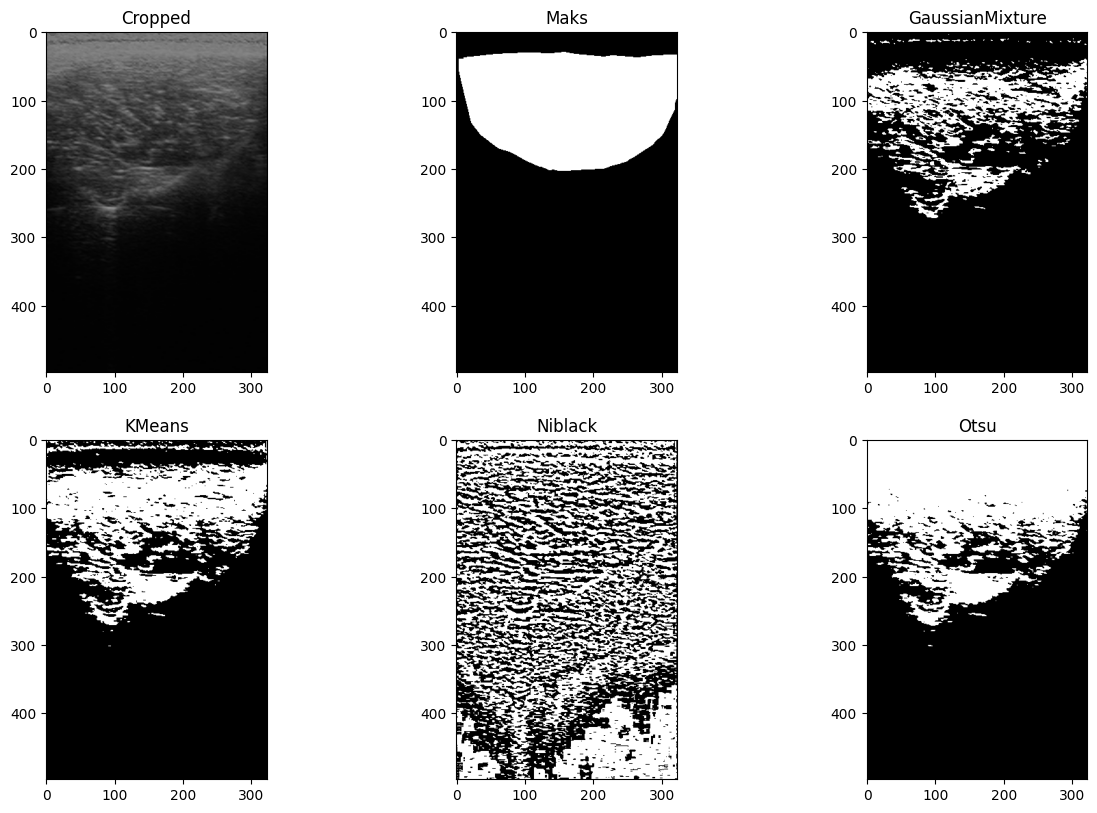

In [154]:
img1 = imread(
    "../ultrassound/cropped/503311001.bmp")
img2 = imread(
    "../ultrassound/GaussianMixture/503311001.bmp")
img3 = imread(
    "../ultrassound/masks/503311001.bmp")
img4 = imread(
    "../ultrassound/seg_kmeans/503311001.bmp")
img5 = imread(
    "../ultrassound/seg_niblack/503311001.bmp")
img6 = imread(
    "../ultrassound/seg_otsu/503311001.bmp")


plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
plt.title("Cropped")
plt.imshow(img1, cmap='gray')
plt.subplot(3, 3, 2)
plt.title("Maks")
plt.imshow(img3, cmap='gray')

plt.subplot(3, 3, 3)
plt.title("GaussianMixture")
plt.imshow(img2, cmap='gray')
plt.subplot(3, 3, 4)
plt.title("KMeans")
plt.imshow(img4, cmap='gray')

plt.subplot(3, 3, 5)
plt.title("Niblack")
plt.imshow(img5, cmap='gray')
plt.subplot(3, 3, 6)
plt.title("Otsu")
plt.imshow(img6, cmap='gray')

plt.show()


### III. Resposta
O metodo de escolha utilizado foi na utilizacao dos centroides do clusters disponibilizados, que atraves de testes chegamos a um intervalo otimo de 0.24 a 0.40.

    if cluster.Center >= 0.24 and cluster.Center <= 0.40:

        Salve a imagem ou Some com a imagem do cluster anterior

Esse sendo um dos nossos maiores erros, sendo possivel tratar melhor os centroides, utilizando pesos para cada um por exemplo e fazer com que a funcao pegue os melhores clusters e una a imagem de saida.

### IV. Resposta

O melhor resultado veio por meio do cluster GaussianMixture, pois, por conta de sua metodologia gaussiana o tratamento das imagens ultrassonograficas encaixou muito bem. Podendo ate ter uma melhora nos resultados se fosse realizado o teste utilizando o GaussianMixture com os parametros do KMeans, contudo esse teste seria 4x mais demorado e com um custo operacional alto.

Um dos pontos fortes do cluster GaussianMixture, eh sua forma de convergir para seus centroides de uma forma eliptica, como mostra no site disponibilizado a solucao da resposta 3.I.

Outra coisa é que GaussianMixture é um algoritmo probabilístico. Ao atribuir as probabilidades aos pontos de dados, podemos expressar quão forte é a possibilidade de que um determinado ponto de dados pertenca a um cluster específico.



### V. Resposta


Escolhemos o KMeans como a melhor técnica de segmentação devido à sua ampla utilização e influência sobre outras técnicas. Embora não tenhamos obtido os melhores resultados em nossos testes, isso foi principalmente devido a uma escolha inadequada dos centroides. No entanto, podemos melhorar os resultados com uma abordagem diferente para a escolha dos centroides e otimização do processo de atribuição de pontos e recalculo dos centros.